In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5655093568438853 	 Validation loss: 0.42026398747654287 	 
  1%|          | 574/57400 [01:43<2:36:37,  6.05it/s]
Epoch 2 	 Training loss: 0.3866663800247455 	 Validation loss: 0.354471822411327 	 
  2%|▏         | 1148/57400 [03:28<2:44:54,  5.69it/s]
Epoch 3 	 Training loss: 0.3455587477011132 	 Validation loss: 0.33686257368427214 	 
  3%|▎         | 1722/57400 [05:14<2:22:18,  6.52it/s]
Epoch 4 	 Training loss: 0.324737484888125 	 Validation loss: 0.3261333853006363 	 
  4%|▍         | 2296/57400 [07:00<2:43:53,  5.60it/s]
Epoch 5 	 Training loss: 0.30887097374695105 	 Validation loss: 0.31962197715953244 	 
  5%|▌         | 2870/57400 [08:46<2:39:07,  5.71it/s]
Epoch 6 	 Training loss: 0.2963370095146658 	 Validation loss: 0.31422945377180134 	 
  6%|▌         | 3444/57400 [10:33<2:58:38,  5.03it/s]
Epoch 7 	 Training loss: 0.2829743333757962 	 Validation loss: 0.308774238168183 	 
  7%|▋         | 4018/57400 [12:20<2:16:12,  6.53it/s]
Epoch 8 	 Training 

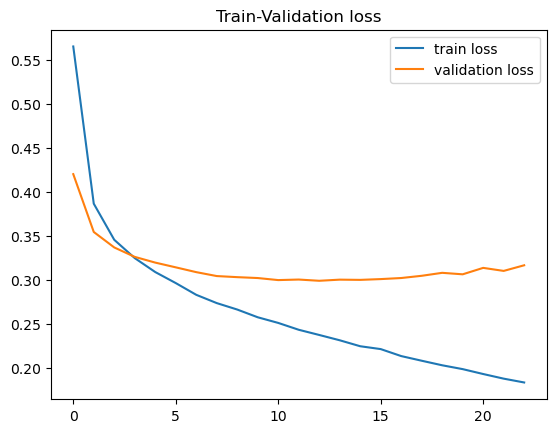

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8520408163265306, 'precision': 0.8520408163265306, 'f1': 0.8520408163265306, 'accuracy': 0.8520408163265306}
MALE {'recall': 0.8723958333333334, 'precision': 0.8723958333333334, 'f1': 0.8723958333333334, 'accuracy': 0.8723958333333334}
FEMALE {'recall': 0.8325, 'precision': 0.8325, 'f1': 0.8325, 'accuracy': 0.8325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6792929292929293, 'precision': 0.6792929292929293, 'f1': 0.6792929292929293, 'accuracy': 0.6792929292929293}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6923076923076923, 'precision': 0.6923076923076923, 'f1': 0.6923076923076923, 'accuracy': 0.6923076923076923}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5750087173558278 	 Validation loss: 0.4183693033153728 	 
  1%|          | 574/57400 [02:02<2:36:54,  6.04it/s]
Epoch 2 	 Training loss: 0.3873410646248778 	 Validation loss: 0.3555866732435711 	 
  2%|▏         | 1148/57400 [03:57<2:51:48,  5.46it/s]
Epoch 3 	 Training loss: 0.3462087019031887 	 Validation loss: 0.3365535523931859 	 
  3%|▎         | 1722/57400 [05:53<2:32:02,  6.10it/s]
Epoch 4 	 Training loss: 0.3250250728080497 	 Validation loss: 0.32612121256731325 	 
  4%|▍         | 2296/57400 [07:49<2:46:57,  5.50it/s]
Epoch 5 	 Training loss: 0.30908188010965076 	 Validation loss: 0.32131686857191183 	 
  5%|▌         | 2870/57400 [09:45<3:05:57,  4.89it/s]
Epoch 6 	 Training loss: 0.29519434444580345 	 Validation loss: 0.31367883313510375 	 
  6%|▌         | 3444/57400 [11:42<2:29:42,  6.01it/s]
Epoch 7 	 Training loss: 0.2853981125645521 	 Validation loss: 0.30981646478176117 	 
  7%|▋         | 4018/57400 [13:38<2:31:57,  5.85it/s]
Epoch 8 	 Train

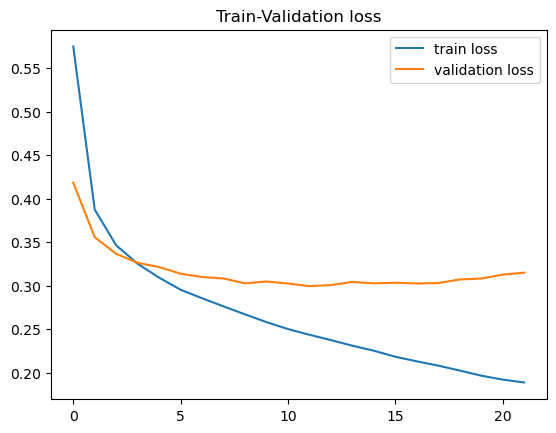

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8533163265306123, 'precision': 0.8533163265306123, 'f1': 0.8533163265306123, 'accuracy': 0.8533163265306123}
MALE {'recall': 0.8697916666666666, 'precision': 0.8697916666666666, 'f1': 0.8697916666666666, 'accuracy': 0.8697916666666666}
FEMALE {'recall': 0.8375, 'precision': 0.8375, 'f1': 0.8375, 'accuracy': 0.8375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6792929292929293, 'precision': 0.6792929292929293, 'f1': 0.6792929292929293, 'accuracy': 0.6792929292929293}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5456650253476166 	 Validation loss: 0.3936839032981355 	 
  1%|          | 574/57400 [01:47<2:43:21,  5.80it/s]
Epoch 2 	 Training loss: 0.3761706803422356 	 Validation loss: 0.3479643171116457 	 
  2%|▏         | 1148/57400 [03:33<3:01:33,  5.16it/s]
Epoch 3 	 Training loss: 0.3420338479328239 	 Validation loss: 0.33410792406332696 	 
  3%|▎         | 1722/57400 [05:19<2:24:22,  6.43it/s]
Epoch 4 	 Training loss: 0.32377949684131435 	 Validation loss: 0.3215320623022015 	 
  4%|▍         | 2296/57400 [07:05<2:41:16,  5.69it/s]
Epoch 5 	 Training loss: 0.30723472920859735 	 Validation loss: 0.31813553783853177 	 
  5%|▌         | 2870/57400 [08:51<2:30:12,  6.05it/s]
Epoch 6 	 Training loss: 0.2948394112989878 	 Validation loss: 0.31267156110981764 	 
  6%|▌         | 3444/57400 [10:37<2:33:42,  5.85it/s]
Epoch 7 	 Training loss: 0.28314688674560407 	 Validation loss: 0.30622845837625406 	 
  7%|▋         | 4018/57400 [12:23<2:14:55,  6.59it/s]
Epoch 8 	 Trai

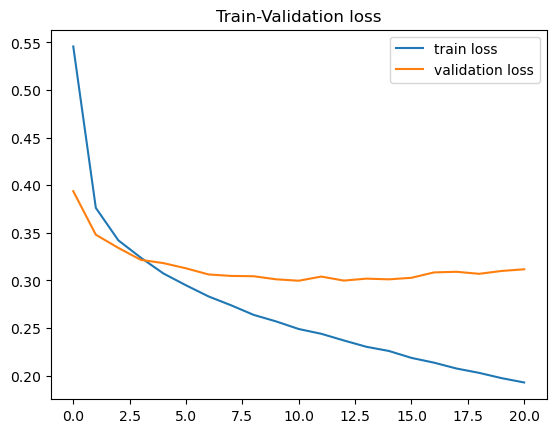

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8520408163265306, 'precision': 0.8520408163265306, 'f1': 0.8520408163265306, 'accuracy': 0.8520408163265306}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6881313131313131, 'precision': 0.6881313131313131, 'f1': 0.6881313131313131, 'accuracy': 0.6881313131313131}
MALE {'recall': 0.7104622871046229, 'precision': 0.7104622871046229, 'f1': 0.7104622871046229, 'accuracy': 0.7104622871046229}
FEMALE {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6844850065189049, 'precision': 0.6844850065189049, 'f1': 0.6844850065189049, 'accuracy': 0.6844850065189049}
MALE {'recall': 0.702020

Resultados finales

In [24]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8524659863945578, 'precision': 0.8524659863945578, 'f1': 0.8524659863945578, 'accuracy': 0.8524659863945578}
Métricas etiqueta male: {'recall': 0.8654513888888888, 'precision': 0.8654513888888888, 'f1': 0.8654513888888888, 'accuracy': 0.8654513888888888}
Métricas etiqueta female:  {'recall': 0.84, 'precision': 0.84, 'f1': 0.84, 'accuracy': 0.84}

 to
Resultado global: {'recall': 0.6822390572390572, 'precision': 0.6822390572390572, 'f1': 0.6822390572390572, 'accuracy': 0.6822390572390572}
Métricas etiqueta male: {'recall': 0.7120843471208435, 'precision': 0.7120843471208435, 'f1': 0.7120843471208435, 'accuracy': 0.7120843471208435}
Métricas etiqueta female:  {'recall': 0.6500437445319335, 'precision': 0.6500437445319335, 'f1': 0.6500437445319335, 'accuracy': 0.6500437445319335}

 as
Resultado global: {'recall': 0.686657974793568, 'precision': 0.686657974793568, 'f1': 0.686657974793568, 'accuracy': 0.686657974793568}
Métricas et

# TO

In [25]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948066290454997 	 Validation loss: 0.6921874436281495 	 
  1%|          | 574/57400 [01:47<2:47:18,  5.66it/s]
Epoch 2 	 Training loss: 0.694217608157766 	 Validation loss: 0.693392985958164 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:34<2:43:35,  5.73it/s]
Epoch 3 	 Training loss: 0.693811094407836 	 Validation loss: 0.6930704217846111 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:21<2:55:55,  5.27it/s]
Epoch 4 	 Training loss: 0.6934877723351588 	 Validation loss: 0.69291160066249 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [07:19<2:49:01,  5.43it/s]
Epoch 5 	 Training loss: 0.6935642594244422 	 Validation loss: 0.6922387278686135 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [09:27<2:39:28,  5.70it/s]
Epoch 6 	 Training loss: 0.6929397786535868 	 Validation loss: 0.6924188712895927 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [11:34<2:59:44,  5.00it/s]
Epoch 7 	 Training lo

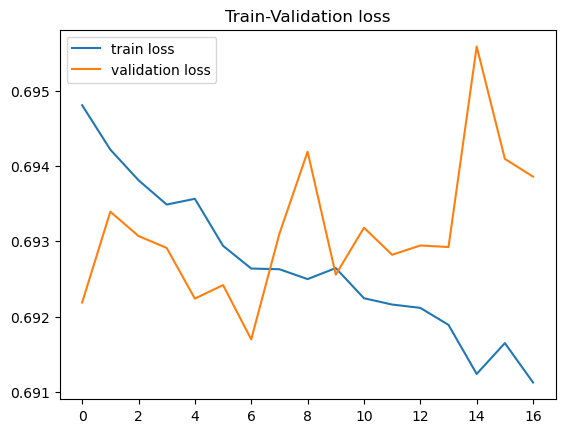

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5216836734693877, 'precision': 0.5216836734693877, 'f1': 0.5216836734693877, 'accuracy': 0.5216836734693877}
MALE {'recall': 0.171875, 'precision': 0.171875, 'f1': 0.171875, 'accuracy': 0.171875}
FEMALE {'recall': 0.8575, 'precision': 0.8575, 'f1': 0.8575, 'accuracy': 0.8575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.170316301703163, 'precision': 0.170316301703163, 'f1': 0.170316301703163, 'accuracy': 0.170316301703163}
FEMALE {'recall': 0.8713910761154856, 'precision': 0.8713910761154856, 'f1': 0.8713910761154856, 'accuracy': 0.8713910761154856} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE {'recall': 0.16161616161616163, 'precision': 0.16161616

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696312234480622 	 Validation loss: 0.6930270538491717 	 
  1%|          | 574/57400 [01:49<2:29:37,  6.33it/s]
Epoch 2 	 Training loss: 0.6943398344392145 	 Validation loss: 0.692688515630819 	 
  2%|▏         | 1148/57400 [03:38<2:24:42,  6.48it/s]
Epoch 3 	 Training loss: 0.6940953763727528 	 Validation loss: 0.6940875386787673 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:27<2:54:40,  5.31it/s]
Epoch 4 	 Training loss: 0.6939299575958517 	 Validation loss: 0.6931960865602655 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [07:16<2:47:42,  5.48it/s]
Epoch 5 	 Training loss: 0.6935031664288418 	 Validation loss: 0.6923916844998376 	 
  5%|▌         | 2870/57400 [09:04<2:51:36,  5.30it/s]
Epoch 6 	 Training loss: 0.6928141415119171 	 Validation loss: 0.6926694077960516 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:52<2:21:23,  6.36it/s]
Epoch 7 	 Training loss: 0.6928189512121553 	 Validation loss: 0.69380658662

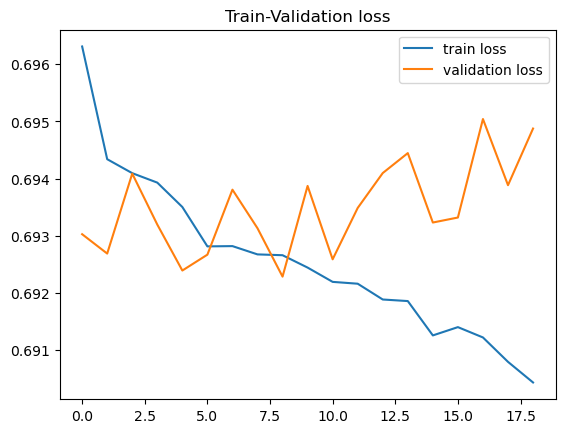

In [28]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5727040816326531, 'precision': 0.5727040816326531, 'f1': 0.5727040816326531, 'accuracy': 0.5727040816326531}
MALE {'recall': 0.3463541666666667, 'precision': 0.3463541666666667, 'f1': 0.3463541666666667, 'accuracy': 0.3463541666666667}
FEMALE {'recall': 0.79, 'precision': 0.79, 'f1': 0.79, 'accuracy': 0.79} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.571969696969697, 'precision': 0.571969696969697, 'f1': 0.571969696969697, 'accuracy': 0.571969696969697}
MALE {'recall': 0.5085158150851582, 'precision': 0.5085158150851582, 'f1': 0.5085158150851582, 'accuracy': 0.5085158150851582}
FEMALE {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5358539765319427, 'precision': 0.5358539765319427, 'f1': 0.5358539765319427, 'accuracy': 0.5358539765319427}
MALE {'recall': 0.3989898989

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970636288048083 	 Validation loss: 0.6934142274371649 	 
  1%|          | 574/57400 [01:50<2:46:52,  5.68it/s]
Epoch 2 	 Training loss: 0.6945199513684582 	 Validation loss: 0.6931424050007836 	 
  2%|▏         | 1148/57400 [03:39<2:46:12,  5.64it/s]
Epoch 3 	 Training loss: 0.6937206719810539 	 Validation loss: 0.6918250150599722 	 
  3%|▎         | 1722/57400 [05:29<2:24:27,  6.42it/s]
Epoch 4 	 Training loss: 0.693548756609395 	 Validation loss: 0.6923439038001885 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:17<2:41:06,  5.70it/s]
Epoch 5 	 Training loss: 0.693273693530817 	 Validation loss: 0.692360730494483 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [09:06<2:20:33,  6.47it/s]
Epoch 6 	 Training loss: 0.6929180766439604 	 Validation loss: 0.6934182259996059 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:54<2:19:36,  6.44it/s]
Epoch 7 	 Training loss: 0.6928187208931621 	 Validation loss: 0.692933450310

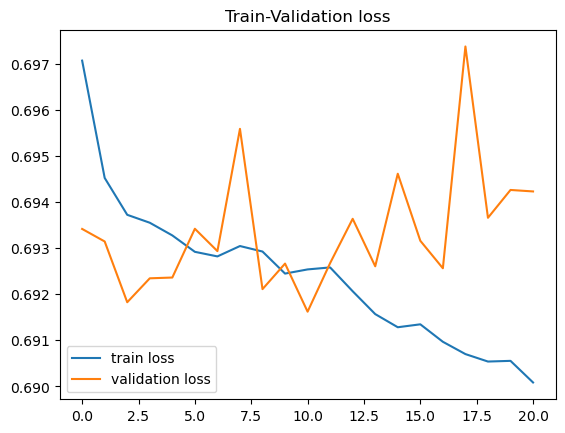

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [31]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5829081632653061, 'precision': 0.5829081632653061, 'f1': 0.5829081632653061, 'accuracy': 0.5829081632653061}
MALE {'recall': 0.46875, 'precision': 0.46875, 'f1': 0.46875, 'accuracy': 0.46875}
FEMALE {'recall': 0.6925, 'precision': 0.6925, 'f1': 0.6925, 'accuracy': 0.6925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5896464646464646, 'precision': 0.5896464646464646, 'f1': 0.5896464646464646, 'accuracy': 0.5896464646464646}
MALE {'recall': 0.48175182481751827, 'precision': 0.48175182481751827, 'f1': 0.48175182481751827, 'accuracy': 0.48175182481751827}
FEMALE {'recall': 0.7060367454068242, 'precision': 0.7060367454068242, 'f1': 0.7060367454068242, 'accuracy': 0.7060367454068242} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5971316818774446, 'precision': 0.5971316818774446, 'f1': 0.5971316818774446, 'accuracy': 0.5971316818774446}
MALE {'recall': 0.5075757575757576, 'precision': 0.50757

Resultados finales

In [32]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5590986394557823, 'precision': 0.5590986394557823, 'f1': 0.5590986394557823, 'accuracy': 0.5590986394557823}
Métricas etiqueta male: {'recall': 0.3289930555555556, 'precision': 0.3289930555555556, 'f1': 0.3289930555555556, 'accuracy': 0.3289930555555556}
Métricas etiqueta female:  {'recall': 0.78, 'precision': 0.78, 'f1': 0.78, 'accuracy': 0.78}

 to
Resultado global: {'recall': 0.5563973063973064, 'precision': 0.5563973063973064, 'f1': 0.5563973063973064, 'accuracy': 0.5563973063973064}
Métricas etiqueta male: {'recall': 0.38686131386861317, 'precision': 0.38686131386861317, 'f1': 0.38686131386861317, 'accuracy': 0.38686131386861317}
Métricas etiqueta female:  {'recall': 0.7392825896762905, 'precision': 0.7392825896762905, 'f1': 0.7392825896762905, 'accuracy': 0.7392825896762905}

 as
Resultado global: {'recall': 0.5475880052151239, 'precision': 0.5475880052151239, 'f1': 0.5475880052151239, 'accuracy': 0.5475880052151239}
Mét

# AS

In [33]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945418206656852 	 Validation loss: 0.6930600818941148 	 
  1%|          | 574/57400 [01:46<2:41:40,  5.86it/s]
Epoch 2 	 Training loss: 0.692872031017463 	 Validation loss: 0.6930099947977875 	 
  2%|▏         | 1148/57400 [03:33<2:23:14,  6.54it/s]
Epoch 3 	 Training loss: 0.6916320871185343 	 Validation loss: 0.6929024154857054 	 
  3%|▎         | 1722/57400 [05:19<2:20:13,  6.62it/s]
Epoch 4 	 Training loss: 0.6897662567552374 	 Validation loss: 0.6910902746653153 	 
  4%|▍         | 2296/57400 [07:06<2:19:32,  6.58it/s]
Epoch 5 	 Training loss: 0.6885855081604748 	 Validation loss: 0.6893487168570697 	 
  5%|▌         | 2870/57400 [08:53<2:34:12,  5.89it/s]
Epoch 6 	 Training loss: 0.6868571380497271 	 Validation loss: 0.690693363294763 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:40<2:38:50,  5.66it/s]
Epoch 7 	 Training loss: 0.6839131792870964 	 Validation loss: 0.6893808326478732 	 

2 epoch without improvement
  7%|▋         | 401

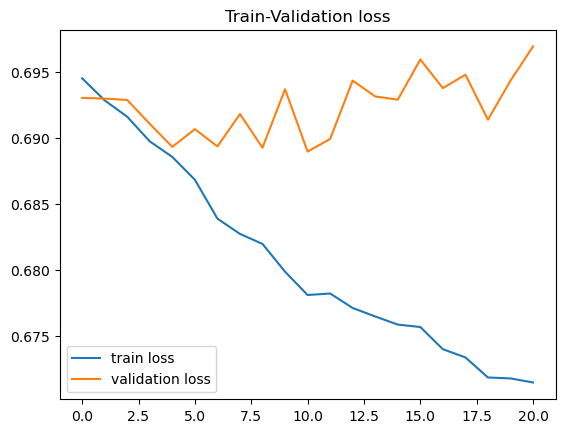

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6683673469387755, 'precision': 0.6683673469387755, 'f1': 0.6683673469387755, 'accuracy': 0.6683673469387755}
MALE {'recall': 0.7395833333333334, 'precision': 0.7395833333333334, 'f1': 0.7395833333333334, 'accuracy': 0.7395833333333334}
FEMALE {'recall': 0.6, 'precision': 0.6, 'f1': 0.6, 'accuracy': 0.6} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7083333333333334, 'precision': 0.7083333333333334, 'f1': 0.7083333333333334, 'accuracy': 0.7083333333333334}
MALE {'recall': 0.781021897810219, 'precision': 0.781021897810219, 'f1': 0.781021897810219, 'accuracy': 0.781021897810219}
FEMALE {'recall': 0.6299212598425197, 'precision': 0.6299212598425197, 'f1': 0.6299212598425197, 'accuracy': 0.6299212598425197} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7979139504563233, 'precision': 0.7979139504563233, 'f1': 0.7979139504563233, 'accuracy': 0.7979139504563233}
MALE {'recall': 0.80303030303030

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944940955173678 	 Validation loss: 0.6932780985104836 	 
  1%|          | 574/57400 [02:02<2:54:10,  5.44it/s]
Epoch 2 	 Training loss: 0.6930998606341225 	 Validation loss: 0.692865742465197 	 
  2%|▏         | 1148/57400 [04:05<2:49:06,  5.54it/s]
Epoch 3 	 Training loss: 0.6921886859870539 	 Validation loss: 0.6913546980437586 	 
  3%|▎         | 1722/57400 [06:08<2:41:29,  5.75it/s]
Epoch 4 	 Training loss: 0.6905544162419615 	 Validation loss: 0.6924191491078522 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:09<2:55:23,  5.24it/s]
Epoch 5 	 Training loss: 0.6891515343239083 	 Validation loss: 0.691868245601654 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:11<2:32:54,  5.94it/s]
Epoch 6 	 Training loss: 0.6878648509339589 	 Validation loss: 0.6918789764582101 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [12:12<2:32:14,  5.91it/s]
Epoch 7 	 Training loss: 0.6872514615075513 	 Validation loss: 0.69357455989

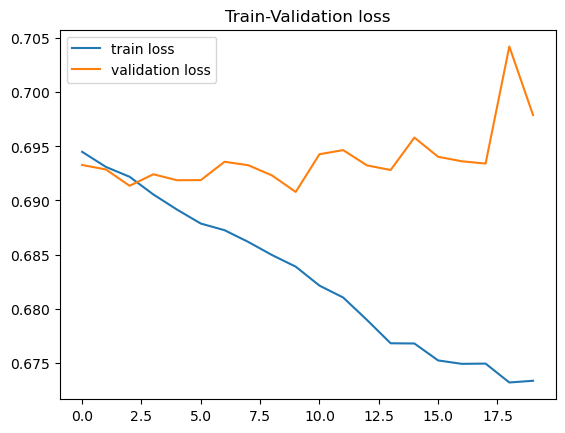

In [36]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5969387755102041, 'precision': 0.5969387755102041, 'f1': 0.5969387755102041, 'accuracy': 0.5969387755102041}
MALE {'recall': 0.5859375, 'precision': 0.5859375, 'f1': 0.5859375, 'accuracy': 0.5859375}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6262626262626263, 'precision': 0.6262626262626263, 'f1': 0.6262626262626263, 'accuracy': 0.6262626262626263}
MALE {'recall': 0.6204379562043796, 'precision': 0.6204379562043796, 'f1': 0.6204379562043796, 'accuracy': 0.6204379562043796}
FEMALE {'recall': 0.6325459317585301, 'precision': 0.6325459317585301, 'f1': 0.6325459317585301, 'accuracy': 0.6325459317585301} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6636245110821382, 'precision': 0.6636245110821382, 'f1': 0.6636245110821382, 'accuracy': 0.6636245110821382}
MALE {'recall': 0.601010101010101, 'precision': 0.60

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947934029409695 	 Validation loss: 0.693190518072096 	 
  1%|          | 574/57400 [01:46<2:22:39,  6.64it/s]
Epoch 2 	 Training loss: 0.6932718760045148 	 Validation loss: 0.6903447731066559 	 
  2%|▏         | 1148/57400 [03:33<2:54:27,  5.37it/s]
Epoch 3 	 Training loss: 0.6917923084534835 	 Validation loss: 0.6911888819629863 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:19<2:45:27,  5.61it/s]
Epoch 4 	 Training loss: 0.6907676171758034 	 Validation loss: 0.6912382123833996 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [07:06<2:38:35,  5.79it/s]
Epoch 5 	 Training loss: 0.6884133316290919 	 Validation loss: 0.6921321183948194 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [08:52<2:46:10,  5.47it/s]
Epoch 6 	 Training loss: 0.6872055115184718 	 Validation loss: 0.6904578491792841 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [10:39<2:21:26,  6.36it/s]
Epoch 7 	 Training loss: 0.6865062987762877 	 

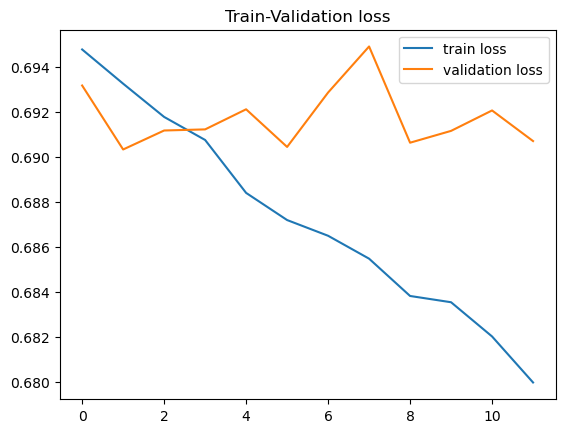

In [38]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_brk_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [39]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5994897959183674, 'precision': 0.5994897959183674, 'f1': 0.5994897959183674, 'accuracy': 0.5994897959183674}
MALE {'recall': 0.5911458333333334, 'precision': 0.5911458333333334, 'f1': 0.5911458333333334, 'accuracy': 0.5911458333333334}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5606060606060606, 'precision': 0.5606060606060606, 'f1': 0.5606060606060606, 'accuracy': 0.5606060606060606}
MALE {'recall': 0.5547445255474452, 'precision': 0.5547445255474452, 'f1': 0.5547445255474452, 'accuracy': 0.5547445255474452}
FEMALE {'recall': 0.5669291338582677, 'precision': 0.5669291338582677, 'f1': 0.5669291338582677, 'accuracy': 0.5669291338582677} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.576271186440678, 'precision': 0.576271186440678, 'f1': 0.576271186440678, 'accuracy': 0.576271186440678}
MALE {'recall': 0.55

Resultados finales

In [40]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6215986394557823, 'precision': 0.6215986394557823, 'f1': 0.6215986394557823, 'accuracy': 0.6215986394557823}
Métricas etiqueta male: {'recall': 0.638888888888889, 'precision': 0.638888888888889, 'f1': 0.638888888888889, 'accuracy': 0.638888888888889}
Métricas etiqueta female:  {'recall': 0.605, 'precision': 0.605, 'f1': 0.605, 'accuracy': 0.605}

 to
Resultado global: {'recall': 0.6317340067340067, 'precision': 0.6317340067340067, 'f1': 0.6317340067340067, 'accuracy': 0.6317340067340067}
Métricas etiqueta male: {'recall': 0.6520681265206812, 'precision': 0.6520681265206812, 'f1': 0.6520681265206812, 'accuracy': 0.6520681265206812}
Métricas etiqueta female:  {'recall': 0.6097987751531059, 'precision': 0.6097987751531059, 'f1': 0.6097987751531059, 'accuracy': 0.6097987751531059}

 as
Resultado global: {'recall': 0.6792698826597131, 'precision': 0.6792698826597131, 'f1': 0.6792698826597131, 'accuracy': 0.6792698826597131}
Métrica